# Production Scheduling Optimization Using CMA-ES

In this notebook, we'll use Covariance Matrix Adaptation Evolution Strategy (CMA-ES) to optimize a production scheduling problem, which is a fundamental challenge in industrial engineering.

## Problem Description

We need to determine the optimal batch sizes and sequence for producing multiple products on a single machine. This involves balancing three key objectives:

1. **Total Production Cost**: Setup costs plus production costs
2. **Makespan**: The total time required to complete all production
3. **Tardiness**: Delays in meeting delivery due dates

These objectives often conflict with each other. For example, minimizing makespan might require smaller batches, which increases setup costs and affects total production cost.

Let's start by importing the required libraries and setting up our problem parameters.

In [66]:
import numpy as np
import cma
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from datetime import datetime, timedelta

## Problem Setup

We'll define the parameters of our scheduling problem, including:

- Number of products
- Setup times between different products
- Processing times for each product
- Production costs
- Due dates

These parameters represent a realistic production environment where changeovers between different products take time and cost money, and products have different processing requirements.

In [67]:
# Number of products
N_PRODUCTS = 4

# Setup times between products (minutes)
SETUP_TIMES = np.array([
    [0, 30, 45, 60],   # From product 1 to products 1,2,3,4
    [30, 0, 40, 50],   # From product 2 to products 1,2,3,4
    [45, 40, 0, 35],   # From product 3 to products 1,2,3,4
    [60, 50, 35, 0]    # From product 4 to products 1,2,3,4
])

# Processing time per unit (minutes)
PROCESSING_TIMES = np.array([5, 7, 6, 8])

# Setup cost per minute
SETUP_COST_RATE = 2.0  # $2 per minute

# Production cost per unit
PRODUCTION_COSTS = np.array([10, 15, 12, 18])

# Holding cost per unit per day
HOLDING_COSTS = np.array([0.5, 0.8, 0.6, 1.0])

# Demand for each product
DEMAND = np.array([100, 80, 120, 60])

# Due dates for each product (in days from start)
DUE_DATES = np.array([5, 3, 7, 4])

# Working hours per day
HOURS_PER_DAY = 8

## Solution Representation

One of the key aspects of using evolutionary algorithms like CMA-ES is how we represent the solution. For our production scheduling problem, we need to determine:

1. The batch size for each product
2. The sequence in which to produce the products

We'll use a simple encoding where:
- The first N values represent the batch sizes
- The next N values represent values that, when sorted, give us the production sequence

Here's how we decode this representation:

In [68]:
def decode_solution(x):
    """
    Decode the CMA-ES solution vector to batch sizes and sequence.
    
    x is structured as:
    [batch_1, batch_2, ..., batch_N, seq_1, seq_2, ..., seq_N]
    
    where batch_i is the batch size for product i
    and seq_i is a value used to determine the sequence
    """
    n = N_PRODUCTS
    
    # Extract batch sizes and sequence values
    batch_sizes = np.round(np.clip(x[:n], 0, DEMAND)).astype(int)
    sequence_values = x[n:2*n]
    
    # Determine sequence by sorting the sequence values
    sequence = np.argsort(sequence_values)
    
    return batch_sizes, sequence

## Objective Functions

Now we'll define three objective functions corresponding to our optimization goals:

1. **Total Production Cost**: Including setup costs and production costs
2. **Makespan**: The total time to complete all production
3. **Tardiness**: Penalties for delivering products after their due dates

Each of these objectives gives us a different perspective on production schedule quality.

In [69]:
def total_production_cost(x):
    """
    Calculate the total production cost including setup costs and production costs.
    """
    batch_sizes, sequence = decode_solution(x)
    
    # Initialize cost
    total_cost = 0
    
    # Add setup costs
    current_product = None
    for product_idx in sequence:
        # Skip products with zero batch size
        if batch_sizes[product_idx] == 0:
            continue
            
        if current_product is not None:
            # Add setup cost
            setup_time = SETUP_TIMES[current_product, product_idx]
            setup_cost = setup_time * SETUP_COST_RATE
            total_cost += setup_cost
            
        current_product = product_idx
        
        # Add production cost
        production_cost = batch_sizes[product_idx] * PRODUCTION_COSTS[product_idx]
        total_cost += production_cost
    
    # Penalize if all batch sizes are zero (invalid solution)
    if np.sum(batch_sizes) == 0:
        return 1000000
    
    # Penalize if not producing enough of any product
    for i in range(N_PRODUCTS):
        if batch_sizes[i] < DEMAND[i]:
            shortage = DEMAND[i] - batch_sizes[i]
            total_cost += shortage * PRODUCTION_COSTS[i] * 3  # High penalty for shortage
    
    return total_cost

def makespan(x):
    """
    Calculate the makespan (total production time) in minutes.
    """
    batch_sizes, sequence = decode_solution(x)
    
    # Initialize time
    total_time = 0
    
    # Add setup and processing times
    current_product = None
    for product_idx in sequence:
        # Skip products with zero batch size
        if batch_sizes[product_idx] == 0:
            continue
            
        if current_product is not None:
            # Add setup time
            total_time += SETUP_TIMES[current_product, product_idx]
            
        current_product = product_idx
        
        # Add processing time
        total_time += batch_sizes[product_idx] * PROCESSING_TIMES[product_idx]
    
    # Penalize if all batch sizes are zero (invalid solution)
    if np.sum(batch_sizes) == 0:
        return 100000
    
    return total_time

def tardiness(x):
    """
    Calculate the total tardiness (sum of delays past due dates) in days.
    """
    batch_sizes, sequence = decode_solution(x)
    
    # Convert minutes to days
    minutes_per_day = HOURS_PER_DAY * 60
    
    # Calculate completion time for each product
    current_time = 0
    current_product = None
    completion_times = np.zeros(N_PRODUCTS)
    
    for product_idx in sequence:
        # Skip products with zero batch size
        if batch_sizes[product_idx] == 0:
            continue
            
        if current_product is not None:
            # Add setup time
            current_time += SETUP_TIMES[current_product, product_idx]
            
        current_product = product_idx
        
        # Add processing time
        current_time += batch_sizes[product_idx] * PROCESSING_TIMES[product_idx]
        
        # Record completion time
        completion_times[product_idx] = current_time / minutes_per_day
    
    # Calculate tardiness (max of 0 and completion time - due date)
    tardiness_values = np.maximum(0, completion_times - DUE_DATES)
    
    # Additional penalty for not producing enough
    for i in range(N_PRODUCTS):
        if batch_sizes[i] < DEMAND[i]:
            tardiness_values[i] += 10  # Big penalty for not meeting demand
    
    return np.sum(tardiness_values)

## Multi-Objective Function

In most real-world industrial engineering problems, we need to balance multiple competing objectives. We'll use a weighted sum approach to combine our three objectives into a single function to optimize.

The weights allow us to adjust the relative importance of each objective based on business priorities:
- Higher weight on cost → More economical schedule
- Higher weight on makespan → Faster completion
- Higher weight on tardiness → Better on-time delivery

In [70]:
def multi_objective(x, weights=[0.4, 0.3, 0.3]):
    """
    Combined objective function using weighted sum approach.
    weights: [cost_weight, makespan_weight, tardiness_weight]
    """
    # Normalize by typical values to make weights meaningful
    cost = total_production_cost(x) / 5000
    span = makespan(x) / 2000
    tardy = tardiness(x) / 10
    
    return (
        weights[0] * cost + 
        weights[1] * span + 
        weights[2] * tardy
    )

<div class="alert alert-block alert-success">
<h2>Exercise: Random solutions</h2>
Using `np.random.rand`, make random solutions and test their fitness on each objective. Then, test their multi-objective fitness. Modify the weights of the fitness to see the impact on the total fitness.
</div>

In [71]:
x=np.random.rand(2*N_PRODUCTS)*100
print(multi_objective(x, weights=[0.5, 0.3, 0.3]))

2.01265


## Visualization

Visualizing the production schedule is crucial for understanding and communicating the optimization results. We'll create two visualization functions:

1. **Schedule Gantt Chart**: Shows the timing of setup and processing activities
2. **Resource Utilization**: Shows how the production resources are being used

These visualizations help stakeholders understand the schedule and identify potential issues or improvements.


In [72]:
def visualize_schedule(batch_sizes, sequence):
    """
    Visualize the production schedule as a Gantt chart.
    """
    # Initialize timeline
    current_time = 0
    current_product = None
    
    # Storage for visualization data
    product_names = [f"Product {i+1}" for i in range(N_PRODUCTS)]
    start_times = []
    durations = []
    categories = []
    colors = []
    
    # Calculate start and end times for each activity
    for product_idx in sequence:
        # Skip products with zero batch size
        if batch_sizes[product_idx] == 0:
            continue
            
        if current_product is not None:
            # Add setup time
            setup_time = SETUP_TIMES[current_product, product_idx]
            
            # Add to visualization data
            start_times.append(current_time)
            durations.append(setup_time)
            categories.append(f"Setup: {product_names[current_product]} → {product_names[product_idx]}")
            colors.append('lightgray')
            
            current_time += setup_time
            
        current_product = product_idx
        
        # Add processing time
        processing_time = batch_sizes[product_idx] * PROCESSING_TIMES[product_idx]
        
        # Add to visualization data
        start_times.append(current_time)
        durations.append(processing_time)
        categories.append(f"Process: {product_names[product_idx]} (Batch: {batch_sizes[product_idx]})")
        colors.append(f"C{product_idx}")
        
        current_time += processing_time
    
    # Create a figure for the Gantt chart
    fig, ax = plt.figure(figsize=(14, 8)), plt.subplot(111)
    
    # Convert to days for better visualization
    minutes_per_day = HOURS_PER_DAY * 60
    start_days = [t / minutes_per_day for t in start_times]
    duration_days = [d / minutes_per_day for d in durations]
    
    # Create a date starting from today for the x-axis
    base_date = datetime.now()
    dates = [base_date + timedelta(days=d) for d in start_days]
    
    # Plot bars for each activity
    for i, (start_date, duration, category, color) in enumerate(zip(dates, duration_days, categories, colors)):
        end_date = start_date + timedelta(days=duration)
        ax.barh(i, (end_date - start_date).total_seconds()/(24*3600), left=mdates.date2num(start_date), height=0.5, 
                color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add text label inside the bar if it's wide enough
        if duration_days[i] > 0.2:  # Only add label if duration > 0.2 days
            ax.text(mdates.date2num(start_date) + (end_date - start_date).total_seconds()/(2*24*3600), 
                    i, category, ha='center', va='center', fontsize=9, color='black')
    
    # Add due date markers
    for i, product_idx in enumerate(range(N_PRODUCTS)):
        due_date = base_date + timedelta(days=int(DUE_DATES[product_idx]))
        y_positions = [j for j, cat in enumerate(categories) if f"Product {product_idx+1}" in cat]
        
        if y_positions:
            # Draw a vertical line at the due date
            ax.axvline(x=mdates.date2num(due_date), color='red', linestyle='--', alpha=0.7)
            
            # Add due date label
            ax.text(mdates.date2num(due_date), max(y_positions) + 0.5, 
                    f"Due: P{product_idx+1}", ha='center', va='bottom', 
                    color='red', fontsize=10, rotation=90)
    
    # Format the x-axis as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    
    # Set y-axis labels and limits
    ax.set_yticks(range(len(categories)))
    ax.set_yticklabels(categories)
    ax.set_ylim(-0.5, len(categories) - 0.5)
    
    # Add grid, title and labels
    ax.grid(axis='x', alpha=0.3)
    ax.set_title('Production Schedule Gantt Chart')
    ax.set_xlabel('Date')
    
    # Add a legend for products
    legend_elements = [patches.Patch(facecolor=f"C{i}", edgecolor='black', linewidth=0.5, 
                                     label=f"Product {i+1}") for i in range(N_PRODUCTS)]
    legend_elements.append(patches.Patch(facecolor='lightgray', edgecolor='black', linewidth=0.5, label='Setup'))
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Also visualize in terms of resource utilization
    visualize_resource_utilization(batch_sizes, sequence)

## Resource Utilization Visualization

This function visualizes how resources are used throughout the production schedule. It shows:

1. A timeline of activities with setup and processing operations
2. A pie chart showing the breakdown of time spent on setup versus actual processing

Understanding resource utilization is critical for identifying efficiency improvements in the production process.

In [73]:
def visualize_resource_utilization(batch_sizes, sequence):
    """
    Visualize resource utilization over time.
    """
    # Calculate timeline
    current_time = 0
    current_product = None
    timestamps = [0]  # Start time
    
    # Store activities and their times
    activities = []
    
    for product_idx in sequence:
        # Skip products with zero batch size
        if batch_sizes[product_idx] == 0:
            continue
            
        if current_product is not None:
            # Add setup time
            setup_time = SETUP_TIMES[current_product, product_idx]
            current_time += setup_time
            timestamps.append(current_time)
            activities.append(f"Setup: P{current_product+1}→P{product_idx+1}")
            
        current_product = product_idx
        
        # Add processing time
        processing_time = batch_sizes[product_idx] * PROCESSING_TIMES[product_idx]
        current_time += processing_time
        timestamps.append(current_time)
        activities.append(f"Process: P{product_idx+1}")
    
    # Convert to days
    minutes_per_day = HOURS_PER_DAY * 60
    days = [t / minutes_per_day for t in timestamps]
    
    # Calculate machine utilization
    setup_time = 0
    processing_time = 0
    idle_time = 0
    
    current_time = 0
    current_product = None
    
    for product_idx in sequence:
        # Skip products with zero batch size
        if batch_sizes[product_idx] == 0:
            continue
            
        if current_product is not None:
            # Add setup time
            setup_time += SETUP_TIMES[current_product, product_idx]
            
        current_product = product_idx
        
        # Add processing time
        processing_time += batch_sizes[product_idx] * PROCESSING_TIMES[product_idx]
    
    total_time = setup_time + processing_time
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot timeline in the first subplot
    ax1.step(days, [0] + [i+1 for i in range(len(activities))], where='post', 
             color='blue', linewidth=2, alpha=0.7)
    
    # Add activity labels
    for i, (activity, start_day) in enumerate(zip(activities, days[:-1])):
        duration = days[i+1] - days[i]
        if duration > 0.1:  # Only add label if duration is significant
            ax1.text(start_day + duration/2, i+1, activity, 
                     ha='center', va='center', fontsize=10, 
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Add due date markers
    for product_idx in range(N_PRODUCTS):
        ax1.axvline(x=DUE_DATES[product_idx], color='red', linestyle='--', alpha=0.5)
        ax1.text(DUE_DATES[product_idx], len(activities)+0.5, 
                f"Due: P{product_idx+1}", ha='center', va='bottom', 
                color='red', fontsize=10, rotation=90)
    
    ax1.set_yticks(range(1, len(activities)+1))
    ax1.set_yticklabels(activities)
    ax1.set_ylim(0, len(activities)+1)
    ax1.set_xlim(0, max(days) * 1.05)
    ax1.set_xlabel('Time (days)')
    ax1.set_title('Production Timeline')
    ax1.grid(True, alpha=0.3)
    
    # Plot resource utilization in the second subplot
    labels = ['Setup', 'Processing']
    sizes = [setup_time / total_time * 100, processing_time / total_time * 100]
    colors = ['lightgray', 'lightblue']
    explode = (0.1, 0)
    
    ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax2.set_title('Resource Utilization')
    
    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-success">
<h2>Exercise: Visualize random solutions</h2>
Using the above functions, visualize the schedules of the random solutions you created.
</div>

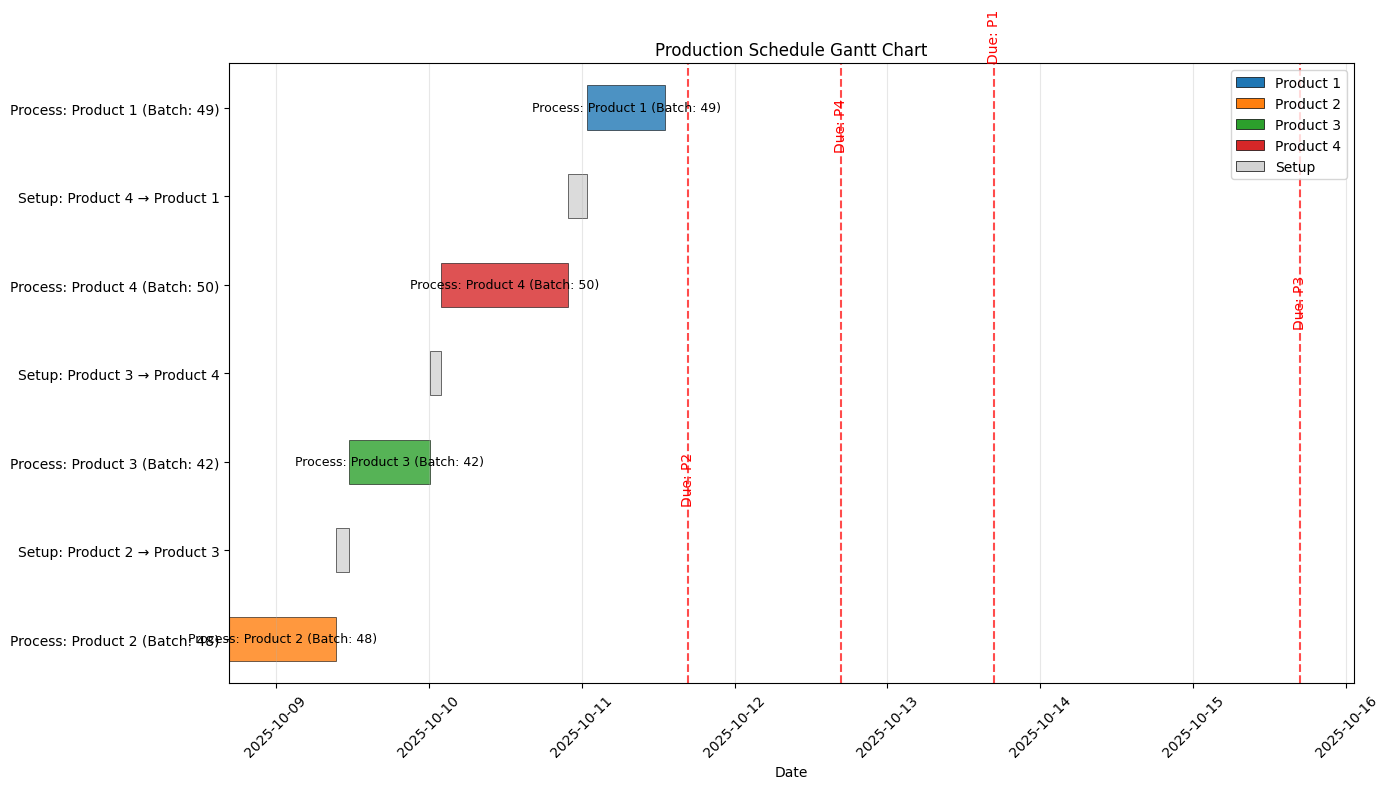

/tmp/ipykernel_52189/3277184742.py:102: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


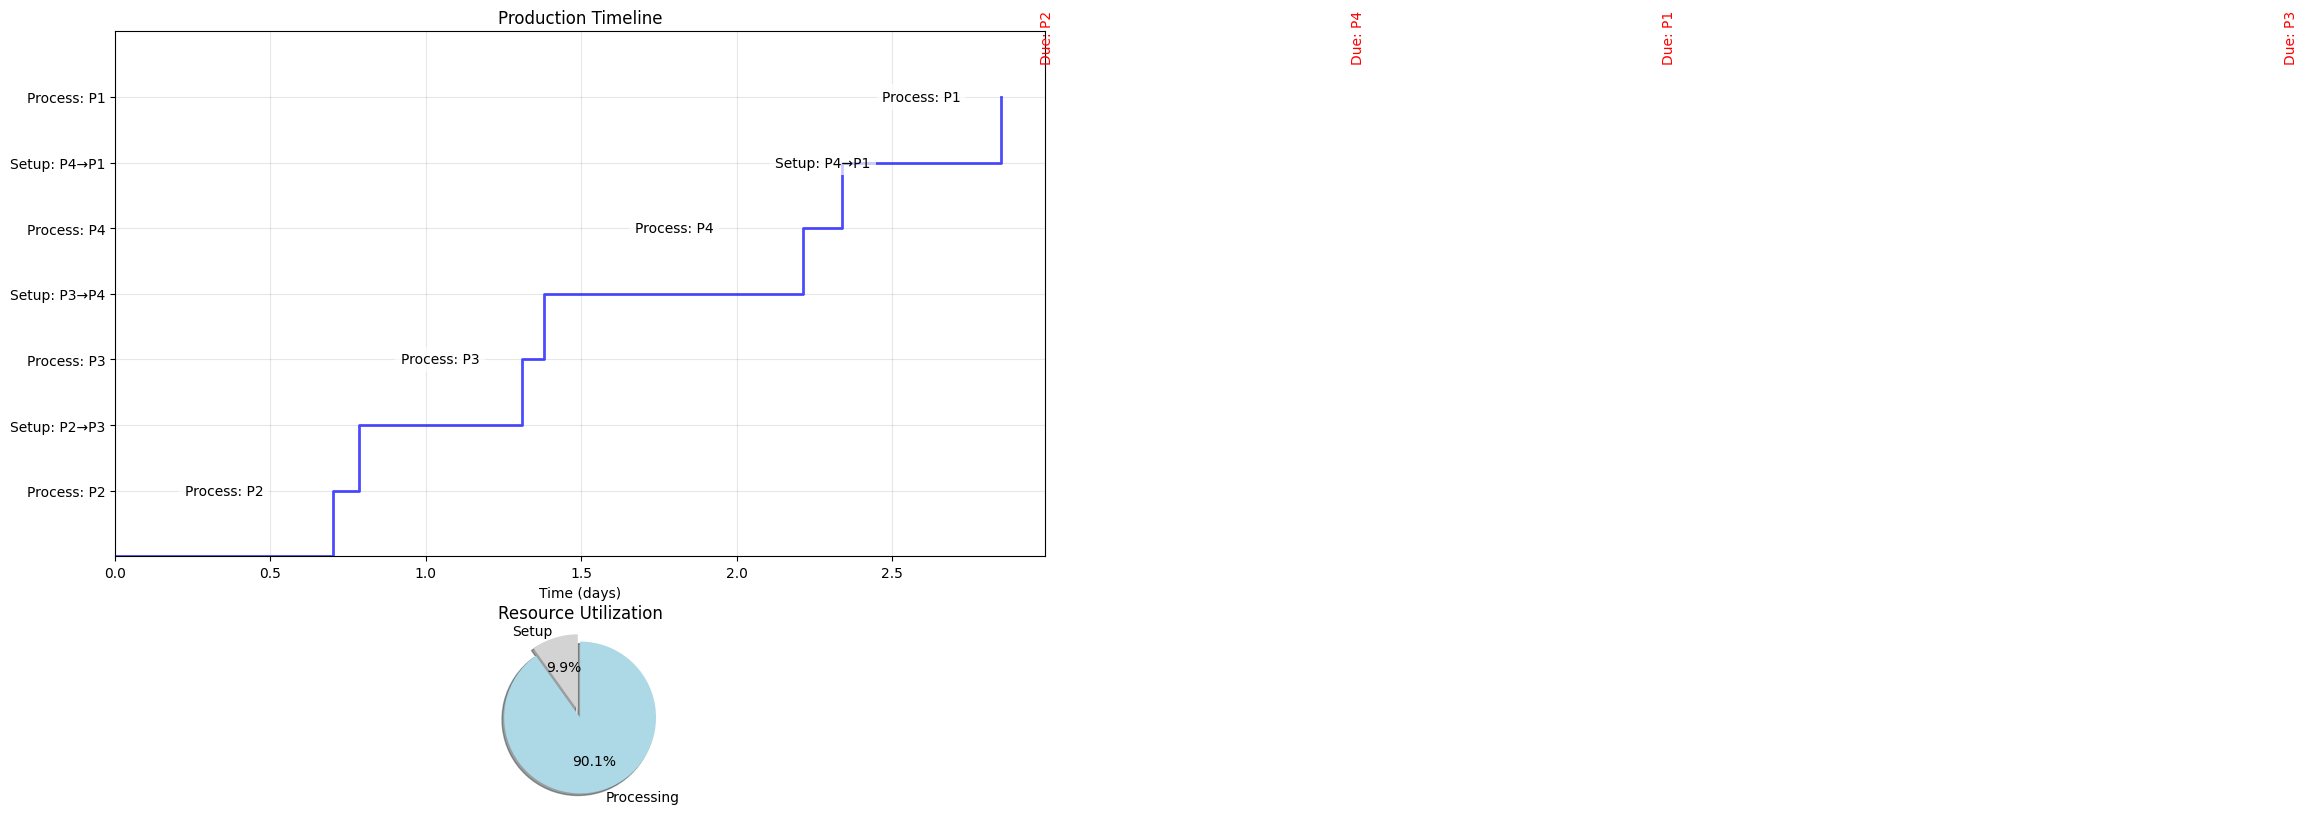

In [74]:
x=np.random.rand(2*N_PRODUCTS)*100
solution=decode_solution(x)
visualize_schedule(*solution)

## Optimization Function

Now we'll create a function that uses CMA-ES to find the optimal production schedule. The function:
1. Sets up the initial solution and parameters
2. Runs the CMA-ES algorithm
3. Decodes and evaluates the final solution
4. Returns and displays the results

CMA-ES is particularly well-suited for this problem because it can effectively navigate the complex, non-linear search space created by the interaction between batch sizes and sequence.

In [85]:
def optimize_production_schedule(weights=[0.4, 0.3, 0.3]):
    """
    Optimize production schedule using CMA-ES.
    """
    print(f"Optimizing production schedule with weights: {weights}")
    
    # Initial solution: equal batch sizes and sequence 1,2,3,4
    x0 = np.zeros(2 * N_PRODUCTS)
    
    # Set initial batch sizes to the demand
    x0[:N_PRODUCTS] = DEMAND
    
    # Set initial sequence values to 1,2,3,4
    x0[N_PRODUCTS:] = np.arange(N_PRODUCTS)
    
    sigma0 = 20  # Initial step size
    
    # Create objective function with fixed weights
    def objective(x):
        return multi_objective(x, weights)
    
    # Run CMA-ES optimization
    result = cma.fmin(objective, x0, sigma0, 
                      options={'maxfevals': 2000, 'verb_disp': 1})
    
    # Get the best solution
    best_solution = result[0]
    best_batches, best_sequence = decode_solution(best_solution)
    
    # Calculate individual objectives
    cost = total_production_cost(best_solution)
    span = makespan(best_solution)
    tardy = tardiness(best_solution)
    
    # Calculate completion days
    minutes_per_day = HOURS_PER_DAY * 60
    total_days = span / minutes_per_day
    
    print("\nOptimization results:")
    print("Product  | Batch Size | Sequence")
    print("-" * 30)
    for i in range(N_PRODUCTS):
        seq_position = np.where(best_sequence == i)[0][0] + 1
        print(f"Product {i+1} | {best_batches[i]:10d} | {seq_position}")
    
    print(f"\nTotal production cost: ${cost:.2f}")
    print(f"Makespan: {span:.2f} minutes ({total_days:.2f} days)")
    print(f"Total tardiness: {tardy:.2f} days")
    print(f"Total weighted objective: {objective(best_solution):.4f}")
    
    return best_batches, best_sequence, cost, span, tardy

## Running the Optimization

Now let's run the optimization and visualize the results. We'll use a balanced weight configuration that gives equal importance to cost, makespan, and tardiness.

The visualization will show us:
1. The optimized batch sizes for each product
2. The production sequence
3. The resulting schedule as a Gantt chart
4. The resource utilization breakdown

In [86]:
# Run basic optimization
best_batches, best_sequence, cost, span, tardy = optimize_production_schedule()

Optimizing production schedule with weights: [0.4, 0.3, 0.3]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=1054144, Wed Oct  8 16:48:41 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 8.088249999999999e-01 1.0e+00 1.83e+01  2e+01  2e+01 0:00.0
    2     20 1.063000000000000e+00 1.3e+00 1.66e+01  2e+01  2e+01 0:00.0
    3     30 7.584500000000001e-01 1.3e+00 1.68e+01  2e+01  2e+01 0:00.0
    4     40 7.569000000000000e-01 1.3e+00 1.71e+01  2e+01  2e+01 0:00.0
    5     50 7.646500000000001e-01 1.4e+00 1.77e+01  2e+01  2e+01 0:00.0
    6     60 7.553500000000000e-01 1.5e+00 1.84e+01  2e+01  2e+01 0:00.0
    7     70 7.522500000000001e-01 1.6e+00 1.82e+01  2e+01  2e+01 0:00.0
    8     80 7.522500000000001e-01 1.8e+00 1.79e+01  2e+01  2e+01 0:00.0
    9     90 7.522500000000001e-01 1.8e+00 1.91e+01  2e+01  2e+01 0:00.0
   10    100 7.522500000000001e-01 1.8e+00 1.91e+01  2e+01  2e+01 0:00.0
Iterat #Fevals   function value  axis ratio  

In [87]:
print(best_batches)

[100  80 120  60]


In [88]:
print(best_sequence)

[0 1 3 2]


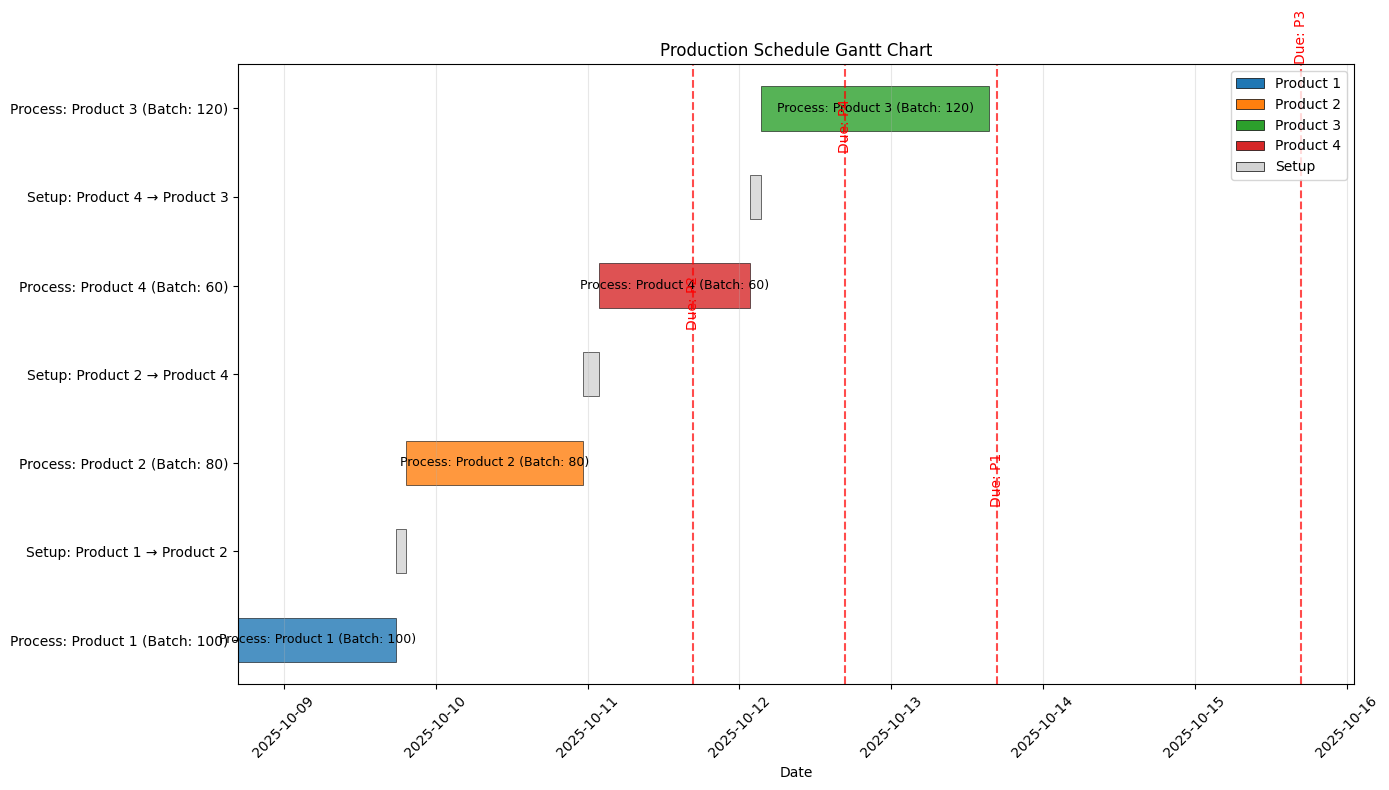

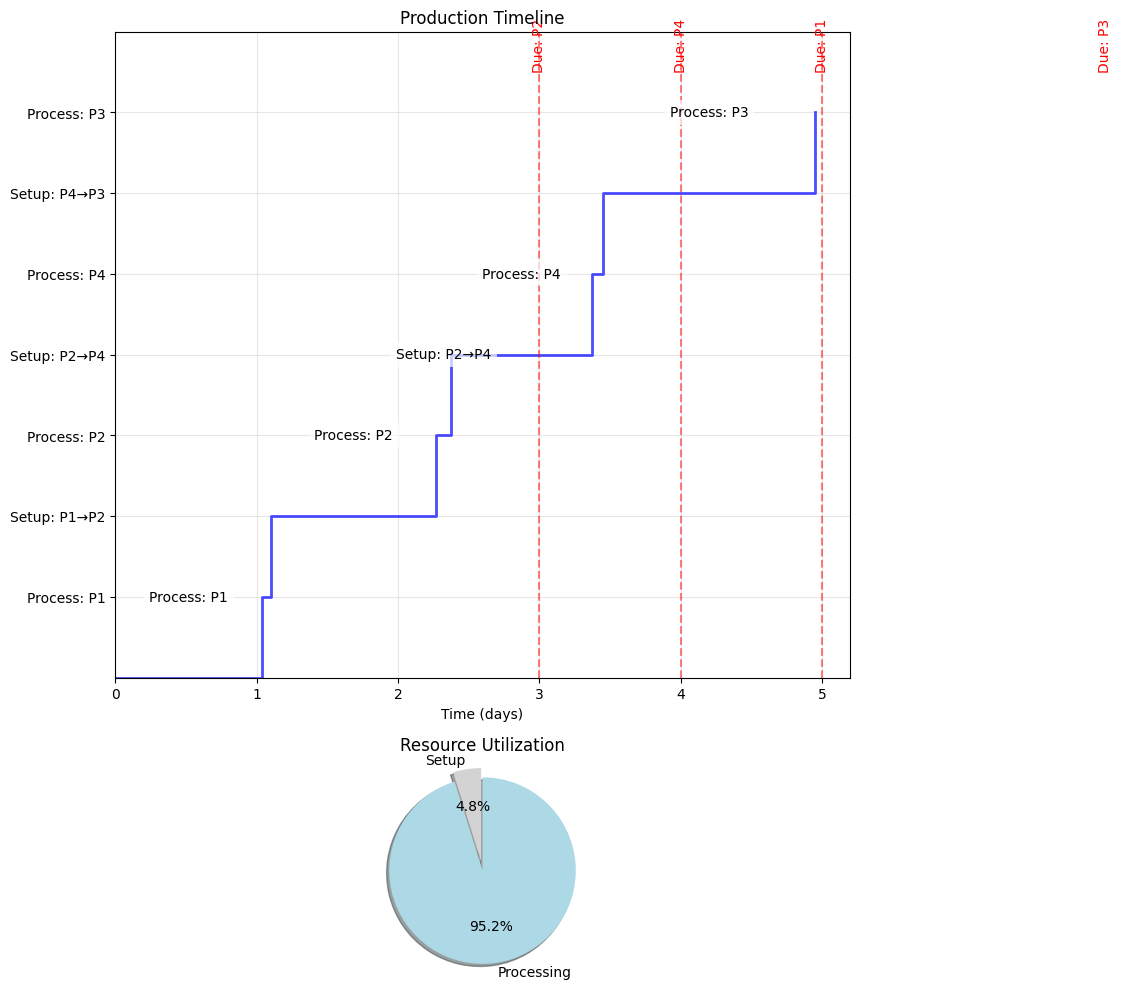

In [79]:
# Visualize the solution
visualize_schedule(best_batches, best_sequence)

## Weight Sensitivity Analysis

An important aspect of multi-objective optimization is understanding how different weight combinations affect the final solution. This function:

1. Optimizes using different weight combinations
2. Visualizes and compares the resulting schedules
3. Shows the trade-offs between cost, makespan, and tardiness

This analysis helps decision-makers understand the sensitivity of the solution to different priorities.

In [89]:
def experiment_with_weights(weight_sets):
    """
    Run optimizations with different weight configurations
    """

    
    results = []
    for weights in weight_sets:
        print(f"\nOptimizing with weights: {weights}")
        best_batches, best_sequence, cost, span, tardy = optimize_production_schedule(weights)
        results.append((best_batches, best_sequence, cost, span, tardy, weights))
        
        # Visualize the last result
        # visualize_schedule(best_batches, best_sequence)
    
    # Compare results
    print("\nComparison of different weight configurations:")
    print("Weights [Cost, Makespan, Tardiness] | Production Cost | Makespan (days) | Tardiness (days)")
    print("-" * 90)
    for batches, sequence, cost, span, tardy, weights in results:
        makespan_days = span / (HOURS_PER_DAY * 60)
        print(f"{weights} | ${cost:.2f} | {makespan_days:.2f} | {tardy:.2f}")
        
        # Plot the production quantities
        plt.figure(figsize=(10, 5))
        bars = plt.bar(range(1, N_PRODUCTS+1), batches, color='skyblue', alpha=0.7, edgecolor='black')
        plt.bar(range(1, N_PRODUCTS+1), DEMAND, alpha=0.3, color='orange', edgecolor='black')
        
        # Add batch size labels on top of bars
        for bar, batch in zip(bars, batches):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    str(batch), ha='center', va='bottom')
        
        plt.xlabel('Product')
        plt.ylabel('Quantity')
        plt.title(f'Production Quantities (Weights: {weights})')
        plt.xticks(range(1, N_PRODUCTS+1))
        plt.legend(['Optimized Batch Size', 'Demand'])
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

In [92]:
weight_sets = [
    [0.8, 0.1, 0.1],  # Focus on cost
#TODO: fill in here
    [0.1,0.8,0.1],
    [0.1,0.1,0.8],
    [0.33,0.33,0.33]
]


Optimizing with weights: [0.8, 0.1, 0.1]
Optimizing production schedule with weights: [0.8, 0.1, 0.1]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=1035877, Wed Oct  8 16:53:58 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.153862500000000e+00 1.0e+00 2.02e+01  2e+01  2e+01 0:00.0
    2     20 9.419541666666668e-01 1.2e+00 1.87e+01  2e+01  2e+01 0:00.0
    3     30 9.282750000000001e-01 1.3e+00 1.90e+01  2e+01  2e+01 0:00.0
    4     40 9.181500000000000e-01 1.4e+00 1.97e+01  2e+01  2e+01 0:00.0
    5     50 9.282750000000001e-01 1.4e+00 1.98e+01  2e+01  2e+01 0:00.0
    6     60 9.144500000000000e-01 1.5e+00 1.93e+01  2e+01  2e+01 0:00.0
    7     70 9.144500000000000e-01 1.5e+00 2.06e+01  2e+01  2e+01 0:00.0
    8     80 9.144500000000000e-01 1.6e+00 2.10e+01  2e+01  2e+01 0:00.0
    9     90 9.144500000000000e-01 1.6e+00 2.15e+01  2e+01  2e+01 0:00.0
   10    100 9.144500000000000e-01 1.7e+00 2.30e+01  2e+01  3e+01 0:00.0
Ite

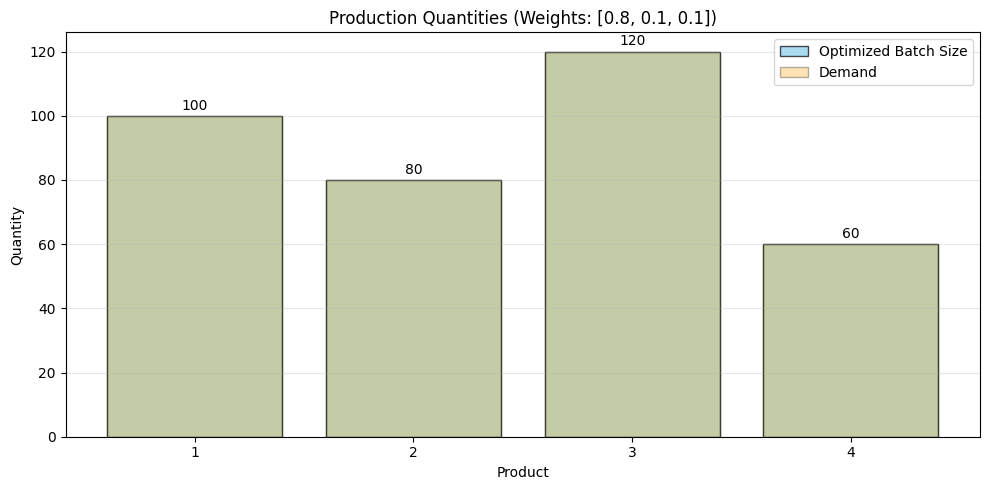

[0.1, 0.8, 0.1] | $4950.00 | 4.95 | 0.00


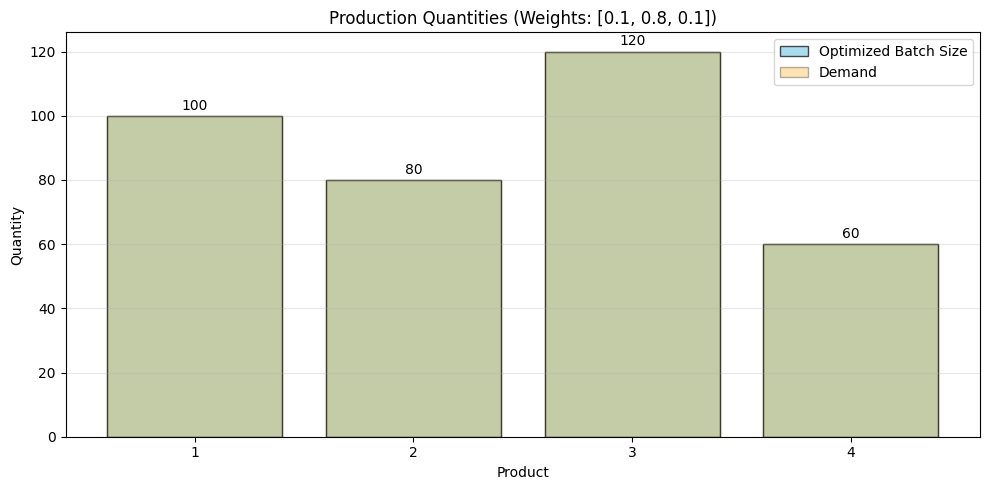

[0.1, 0.1, 0.8] | $4970.00 | 4.97 | 0.00


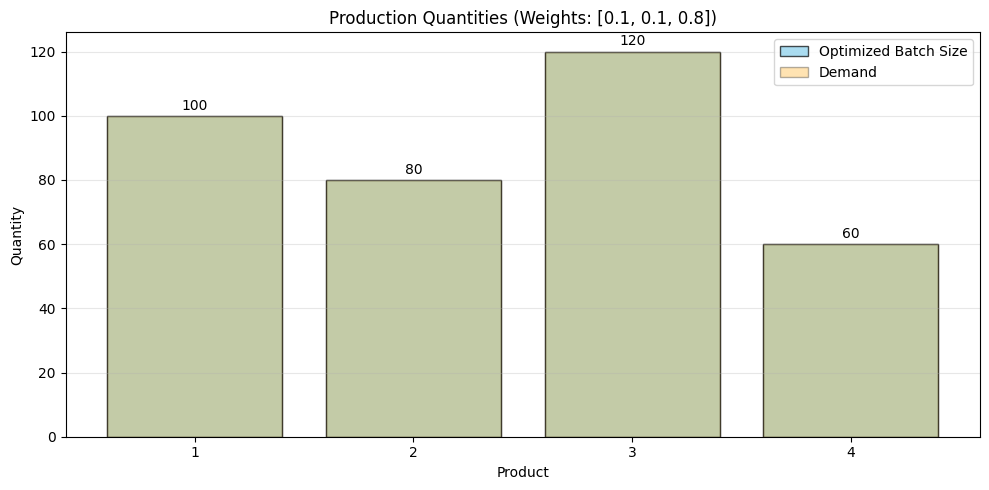

[0.33, 0.33, 0.33] | $4990.00 | 4.99 | 0.00


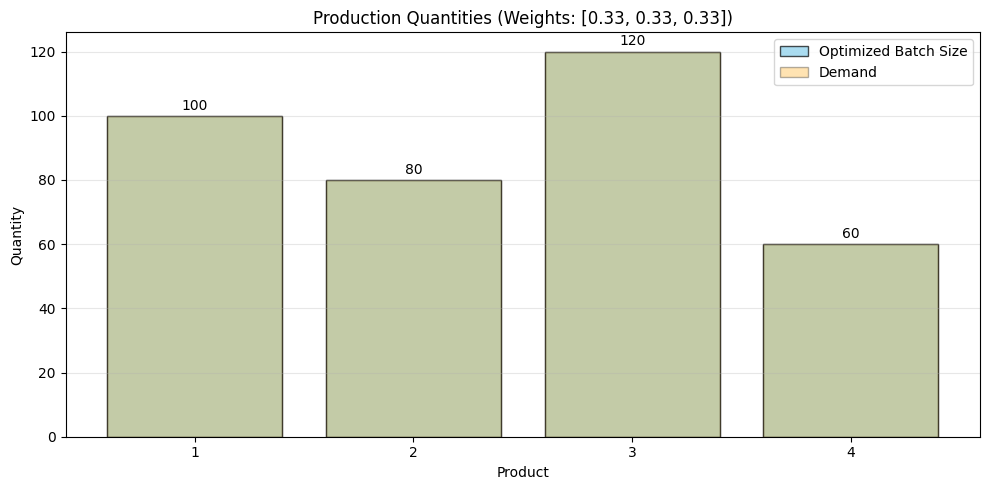

In [93]:
# Run experiments with different weights
experiment_with_weights(weight_sets)

<div class="alert alert-block alert-success">
<h2>Exercise: Different weight combinations</h2>

Compare different weight combinations. Each weight combination should sum to 1. Try configurations that heavily cost, span, and delay, as well as one that is equal. Using the above functions, solve these combinations using CMA-ES and plot the results.</div>

## Conclusion and Extensions

In this notebook, we've explored how to use CMA-ES to optimize a production scheduling problem with multiple competing objectives. We've seen how different weight combinations lead to different trade-offs between cost, makespan, and tardiness.

Real-world production scheduling often involves additional complexities that could be incorporated into this model:

1. **Multiple machines**: Extending to parallel or flow shop scheduling
2. **Sequence-dependent setup times and costs**: More complex setup matrices
3. **Material constraints**: Considering raw material availability
4. **Worker constraints**: Considering shift schedules and labor availability
5. **Preventive maintenance**: Scheduling downtime for equipment maintenance

Furthermore, alternative approaches to multi-objective optimization could be explored:

1. **Pareto optimization**: Finding the complete set of non-dominated solutions
2. **Constraint-based optimization**: Setting hard constraints on some objectives
3. **Hierarchical optimization**: Optimizing objectives in order of priority

The CMA-ES approach demonstrated here provides a flexible framework that can be adapted to these more complex scenarios, making it a valuable tool for industrial engineers tackling real-world production scheduling challenge.